In [1]:
# Importing libraries
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import requests
import seaborn as sns

from sklearn.metrics import classification_report, plot_confusion_matrix, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from typing import List, Optional

## EDA

In [2]:
BASE_URL = 'https://xenabrowser.net/datapages/?cohort=Breast%20Cancer%20(Miller%202005)&removeHub=https%3A%2F%2Fxena.treehouse.gi.ucsc.edu%3A443'
PHENOTYPE_URL = 'https://ucsc-public-main-xena-hub.s3.us-east-1.amazonaws.com/download/miller2005_public%2Fmiller2005_public_clinicalMatrix.gz'
GENE_EXP = 'https://ucsc-public-main-xena-hub.s3.us-east-1.amazonaws.com/download/miller2005_public%2Fmiller2005_genomicMatrix.gz'

In [3]:
filename = PHENOTYPE_URL.split("/")[-1]
with open(filename, "wb") as f:
    r = requests.get(PHENOTYPE_URL)
    f.write(r.content)

In [4]:
import gzip
with gzip.open(filename) as f:
    pheno_df = pd.read_csv(f, sep='\t')

In [5]:
pheno_df

,sampleID,AgeAtDiagnosis,DLDAerror,DSS,DSS.time,ERstatus,EistonHistologicGrade,LymphNodeStatus,PgRstatus,TumorSize,_INTEGRATION,_PATIENT,p53DLDAclassResult,p53mutant,_GENOMIC_ID_miller2005
0,X100B08,68,No,AliveOrCensored,12.0,ER+,G1,LN-,PgR-,9.0,X100B08,X100B08,WT-like,p53-,X100B08
1,X101B88,40,No,AliveOrCensored,12.0,ER-,G3,LN-,PgR-,12.0,X101B88,X101B88,MT-like,p53+,X101B88
2,X102B06,51,No,AliveOrCensored,12.0,ER+,G3,LN-,PgR+,26.0,X102B06,X102B06,MT-like,p53+,X102B06
3,X103B41,52,Yes,NaN,NaN,ER-,G3,LN+,PgR-,22.0,X103B41,X103B41,MT-like,p53-,X103B41
4,X104B91,80,Yes,AliveOrCensored,4.0,ER+,G3,NaN,PgR+,24.0,X104B91,X104B91,WT-like,p53+,X104B91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,X90A63,76,Yes,AliveOrCensored,3.0,ER+,G3,LN-,PgR-,26.0,X90A63,X90A63,MT-like,p53-,X90A63
247,X94A16,73,No,NaN,NaN,ER+,G2,LN-,PgR+,6.0,X94A16,X94A16,WT-like,p53-,X94A16
248,X96A21,63,No,DeathFromCancer,0.0,ER+,G2,LN+,PgR+,38.0,X96A21,X96A21,WT-like,p53-,X96A21
249,X99A50,82,Yes,AliveOrCensored,11.0,ER+,G1,LN-,PgR+,19.0,X99A50,X99A50,WT-like,p53+,X99A50


In [6]:
# Check the equality of sampleID and some other columns 
pheno_df['sampleID'].equals(
    pheno_df['_INTEGRATION']) and pheno_df['_GENOMIC_ID_miller2005'].equals(
        pheno_df['_PATIENT']) and pheno_df['sampleID'].equals(
            pheno_df['_PATIENT'])

True

In [7]:
# Dropping columns which are equal to sampleID column
pheno_df.drop(['_INTEGRATION', '_PATIENT', '_GENOMIC_ID_miller2005'], axis=1, inplace=True)
pheno_df

,sampleID,AgeAtDiagnosis,DLDAerror,DSS,DSS.time,ERstatus,EistonHistologicGrade,LymphNodeStatus,PgRstatus,TumorSize,p53DLDAclassResult,p53mutant
0,X100B08,68,No,AliveOrCensored,12.0,ER+,G1,LN-,PgR-,9.0,WT-like,p53-
1,X101B88,40,No,AliveOrCensored,12.0,ER-,G3,LN-,PgR-,12.0,MT-like,p53+
2,X102B06,51,No,AliveOrCensored,12.0,ER+,G3,LN-,PgR+,26.0,MT-like,p53+
3,X103B41,52,Yes,NaN,NaN,ER-,G3,LN+,PgR-,22.0,MT-like,p53-
4,X104B91,80,Yes,AliveOrCensored,4.0,ER+,G3,NaN,PgR+,24.0,WT-like,p53+
...,...,...,...,...,...,...,...,...,...,...,...,...
246,X90A63,76,Yes,AliveOrCensored,3.0,ER+,G3,LN-,PgR-,26.0,MT-like,p53-
247,X94A16,73,No,NaN,NaN,ER+,G2,LN-,PgR+,6.0,WT-like,p53-
248,X96A21,63,No,DeathFromCancer,0.0,ER+,G2,LN+,PgR+,38.0,WT-like,p53-
249,X99A50,82,Yes,AliveOrCensored,11.0,ER+,G1,LN-,PgR+,19.0,WT-like,p53+


In [8]:
pheno_df.shape

(251, 12)

In [9]:
pheno_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sampleID               251 non-null    object 
 1   AgeAtDiagnosis         251 non-null    int64  
 2   DLDAerror              251 non-null    object 
 3   DSS                    236 non-null    object 
 4   DSS.time               236 non-null    float64
 5   ERstatus               247 non-null    object 
 6   EistonHistologicGrade  249 non-null    object 
 7   LymphNodeStatus        242 non-null    object 
 8   PgRstatus              251 non-null    object 
 9   TumorSize              251 non-null    float64
 10  p53DLDAclassResult     251 non-null    object 
 11  p53mutant              251 non-null    object 
dtypes: float64(2), int64(1), object(9)
memory usage: 23.7+ KB


In [10]:
# Columns which have missing values
pheno_df.columns[pheno_df.isna().any()]

Index(['DSS', 'DSS.time', 'ERstatus', 'EistonHistologicGrade',
       'LymphNodeStatus'],
      dtype='object')

In [11]:
# Check unique values of categorical data
for col in pheno_df.columns[np.r_[2:4, 5:9, 10: 12]]:
    print(f'{col}: {pheno_df[col].unique()}')

DLDAerror: ['No' 'Yes']
DSS: ['AliveOrCensored' nan 'DeathFromCancer']
ERstatus: ['ER+' 'ER-' nan]
EistonHistologicGrade: ['G1' 'G3' 'G2' nan]
LymphNodeStatus: ['LN-' 'LN+' nan]
PgRstatus: ['PgR-' 'PgR+']
p53DLDAclassResult: ['WT-like' 'MT-like']
p53mutant: ['p53-' 'p53+']


In [12]:
cleanup = {
    'DLDAerror': {
        'No': 0,
        'Yes': 1
    },
    'DSS': {
        'DeathFromCancer': 0,
        'AliveOrCensored': 1
    },
    'ERstatus': {
        'ER-': 0,
        'ER+': 1
    },
    'LymphNodeStatus': {
        'LN-': 0,
        'LN+': 1
    },
    'PgRstatus': {
        'PgR-': 0,
        'PgR+': 1
    },
    'p53DLDAclassResult': {
        'WT-like': 0,
        'MT-like': 1
    },
    'p53mutant': {
        'p53-': 0,
        'p53+': 1
    },
    'EistonHistologicGrade': {
        'G1': 0,
        'G2': 1,
        'G3': 2
    }
}
pheno_df.replace(cleanup, inplace=True)

In [13]:
pheno_df

,sampleID,AgeAtDiagnosis,DLDAerror,DSS,DSS.time,ERstatus,EistonHistologicGrade,LymphNodeStatus,PgRstatus,TumorSize,p53DLDAclassResult,p53mutant
0,X100B08,68,0,1.0,12.0,1.0,0.0,0.0,0,9.0,0,0
1,X101B88,40,0,1.0,12.0,0.0,2.0,0.0,0,12.0,1,1
2,X102B06,51,0,1.0,12.0,1.0,2.0,0.0,1,26.0,1,1
3,X103B41,52,1,NaN,NaN,0.0,2.0,1.0,0,22.0,1,0
4,X104B91,80,1,1.0,4.0,1.0,2.0,NaN,1,24.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
246,X90A63,76,1,1.0,3.0,1.0,2.0,0.0,0,26.0,1,0
247,X94A16,73,0,NaN,NaN,1.0,1.0,0.0,1,6.0,0,0
248,X96A21,63,0,0.0,0.0,1.0,1.0,1.0,1,38.0,0,0
249,X99A50,82,1,1.0,11.0,1.0,0.0,0.0,1,19.0,0,1


In [14]:
df_dropped = pheno_df.copy(); df_dropped.dropna(inplace=True)
# Convert ordinal columns data type to Int64
df_dropped[['DSS', 'ERstatus', 'EistonHistologicGrade',
          'LymphNodeStatus']] = df_dropped[[
              'DSS', 'ERstatus', 'EistonHistologicGrade', 'LymphNodeStatus'
          ]].astype('int64')
df_dropped.head()

,sampleID,AgeAtDiagnosis,DLDAerror,DSS,DSS.time,ERstatus,EistonHistologicGrade,LymphNodeStatus,PgRstatus,TumorSize,p53DLDAclassResult,p53mutant
0,X100B08,68,0,1,12.0,1,0,0,0,9.0,0,0
1,X101B88,40,0,1,12.0,0,2,0,0,12.0,1,1
2,X102B06,51,0,1,12.0,1,2,0,1,26.0,1,1
5,X105B13,46,0,1,12.0,1,0,0,1,13.0,0,0
6,X106B55,37,0,0,7.0,1,0,0,1,60.0,0,0


## Supervised

### Regression

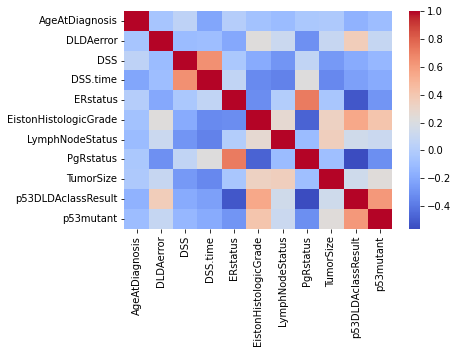

In [15]:
# Correlations among the features
sns.heatmap(df_dropped.corr(), cmap='coolwarm')
plt.show()

In [16]:
# Train-test split
def data_split(dataframe: pd.DataFrame = df_dropped,
               neg_X_columns: List[str] = ['TumorSize'],
               y_column: str = 'TumorSize',
               test_size: float = 0.30):
    '''Split data as train and test according to the flags

    Parameters
    ----------
    neg_X_columns: List[str]
        List of columns to exclude for data
        
    y_column: str
        Target/Label column

    test_size: float
        Test size

    Returns [1]
    -------
    splitting : list, length=2 * len(arrays)
        List containing train-test split of inputs.
    
    [1] https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/model_selection/_split.py
    '''

    X_train, X_test, y_train, y_test = train_test_split(
        dataframe[dataframe.columns.difference(neg_X_columns)],
        dataframe.loc[:, y_column],
        test_size=test_size,
        random_state=42)
    return (X_train, X_test, y_train, y_test)

In [17]:
# Dummy regressor to set a baseline to compare against the other more complex regressors
# in other words to check whether the regression models perform better than simple rules
from sklearn.dummy import DummyRegressor


def dummyreg(X_train, X_test, y_train, y_test, strategy="mean"):
    dummy_regr = DummyRegressor(strategy=strategy)
    dummy_regr.fit(X_train, y_train)
    print(dummy_regr.score(X_test, y_test))

In [18]:
dummyreg(*data_split(neg_X_columns=['TumorSize', 'sampleID']))

-0.05473436845722168


### Classification

In [19]:
# Dummy classifier to set a baseline to compare against the other more complex classifiers
# in other words To check whether the ML models perform better than randomly guessing the labels
from sklearn.dummy import DummyClassifier


def dummyclf(X_train, X_test, y_train, y_test, strategy="prior"):
    dummy_clf = DummyClassifier(strategy=strategy)
    dummy_clf.fit(X_train, y_train)
    # Classification report of the dummy classifier
    print((classification_report(y_test, dummy_clf.predict(X_test), zero_division=0)))
    # Plotting Confusion matrix of the dummy classifier
    plot_confusion_matrix(dummy_clf, X_test, y_test)
    plt.show()

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.57      1.00      0.72        38
           2       0.00      0.00      0.00        16

    accuracy                           0.57        67
   macro avg       0.19      0.33      0.24        67
weighted avg       0.32      0.57      0.41        67



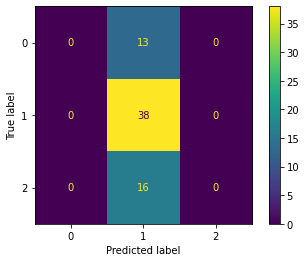

In [20]:
dummyclf(*data_split(neg_X_columns=['EistonHistologicGrade', 'sampleID'], y_column='EistonHistologicGrade'))